# **Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [4]:
data = pd.read_csv('/datasets/games.csv')

In [ ]:
display(data.head(5))
data.info()
data.isna().sum()

**Предварительный анализ данных**

Исходя из первых пяти строк таблицы и информации, которую нам дал метод info(), можно заметить, что :
* Видны пропущенные знаения в столбцах name, year_of_release, critic_score, user_score и rating, и в последних трех пропуски составляют значительную часть данных, поэтому исключить строки с пропущенными значениями в этих столбцах нельзя.
* в столбце user_score присутствует нетипичное значение "tbd", которое явно не может являться оценкой пользователей, поэтому нужно будет перезаписать или удалить строки с этим значением.
* Столбцы таблицы нужно будет превести к нижнему регистру, чтобы с ними быо удобнее работать
* Если посмотреть на медианы и средние стобцов с продажами по регионам, то можно заметить, что медианные значения в разы меньше средних, это может свидетельствовать о наличии выбросов в значениях этих столбцов

In [36]:
data.columns = data.columns.str.lower()

In [37]:
data['year_of_release'] = pd.DatetimeIndex(pd.to_datetime(data['year_of_release'],format='%Y')).year
data['user_score'] = pd.to_numeric(data['user_score'],errors ='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [38]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [39]:
data = data.dropna(subset=['name','year_of_release']).reset_index(drop = True)
data['critic_score'] = data['critic_score'].fillna(0)
data['user_score'] = data['user_score'].fillna(0)
data['rating'] = data['rating'].fillna('unknown')
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

# **Подготовка данных:**

В процессе подготовки данных я изменила типы значений некоторых столбцов: столбец year_of_release привела к типу инт, чтобы удобнее было работать с годом выпуска ( это всегда целое значение), user_score к типу float, так как это дробные числовые значения. Также я оценила, какой процент от всех значений в столбцах составляют пропуски, поэтому я удалила те строки, где пропуски составляли менее 1% (столбцы name, year_of_release), а остальные пропуски в столбцах critic_score, user_score и rating заменила на 0 и 'unknown', так как информация о количестве пропусков может в дальнейшем повлиять на исследование. Причиной пропущенных значений может послужить либо человеческий фактор ( невнимательное заполнение и др.), либо отсутствие\неоднозначность информации в открытых источниках, так как именно оттуда брались данные для базы данных.



In [5]:
data.groupby(by = 'year_of_release')['name'].count()

**Мы видим, что в период с 2006г. по 2011г. выпускалось более 1000 игр в год, а в период с 1980г. по 1993г.  - меньше ста, в некоторые года даже меньше 20. Поэтому данные по самым ранним играм сильного влияния на общую картину не окажут.**

# Анализ продаж по платформам и прогноз на 2017 год

In [41]:
data.groupby(by = 'platform')['total_sales'].sum().sort_values(ascending = False).head(10)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64

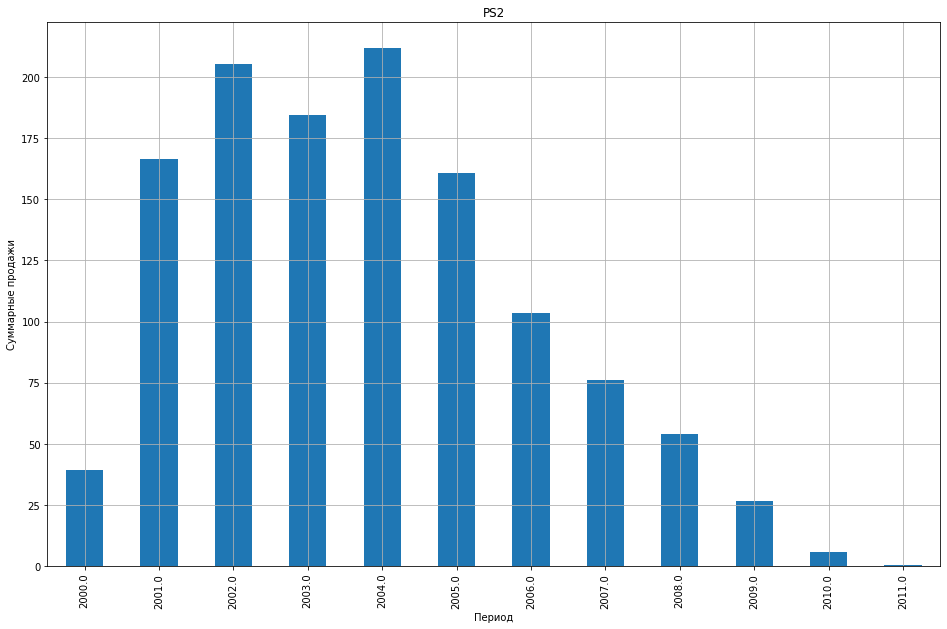

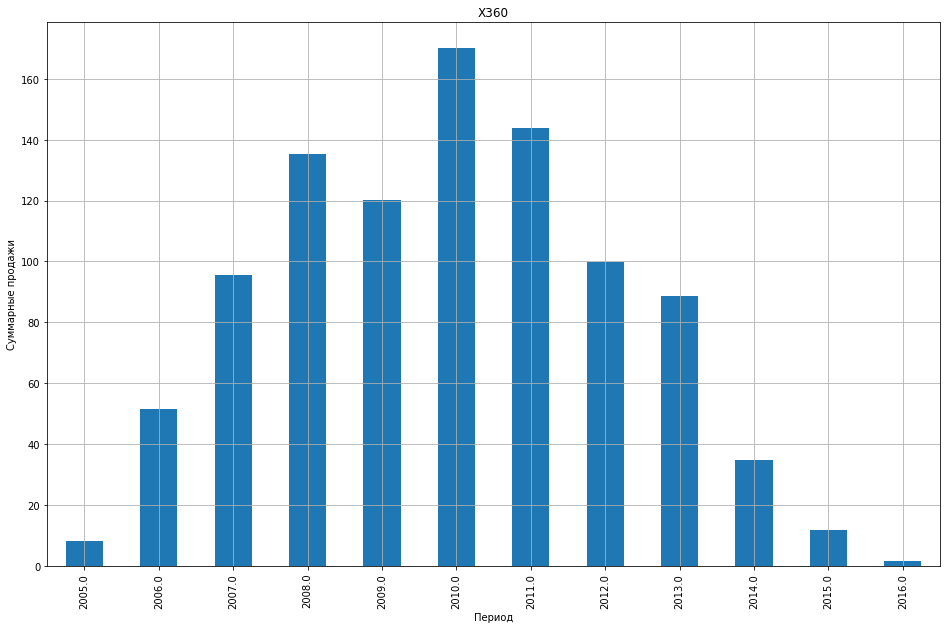

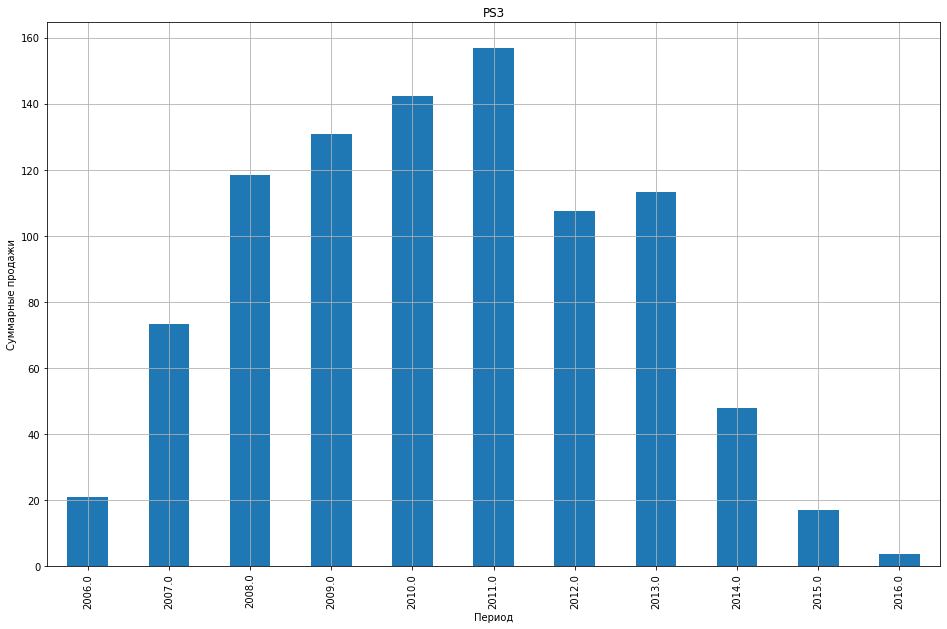

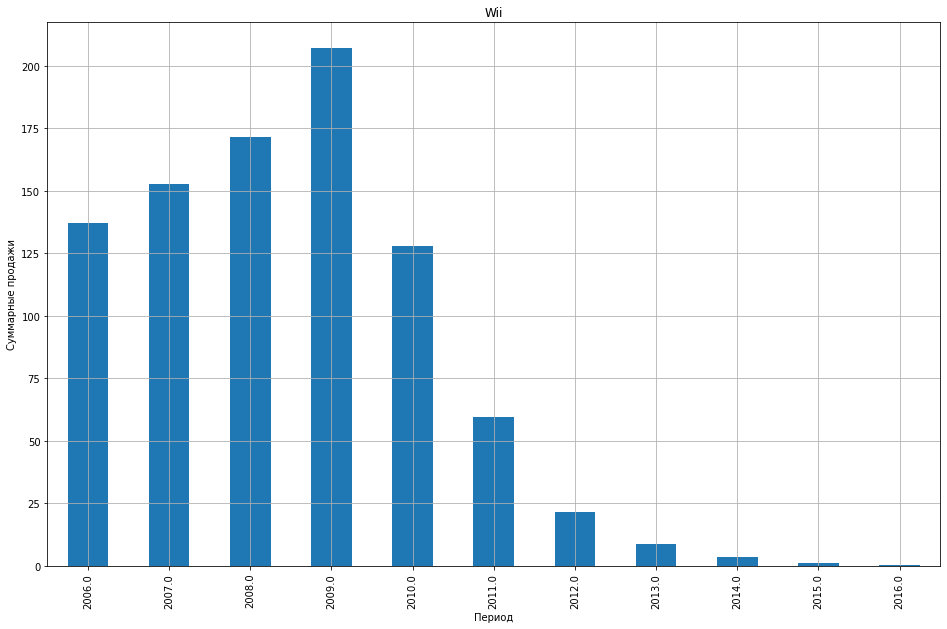

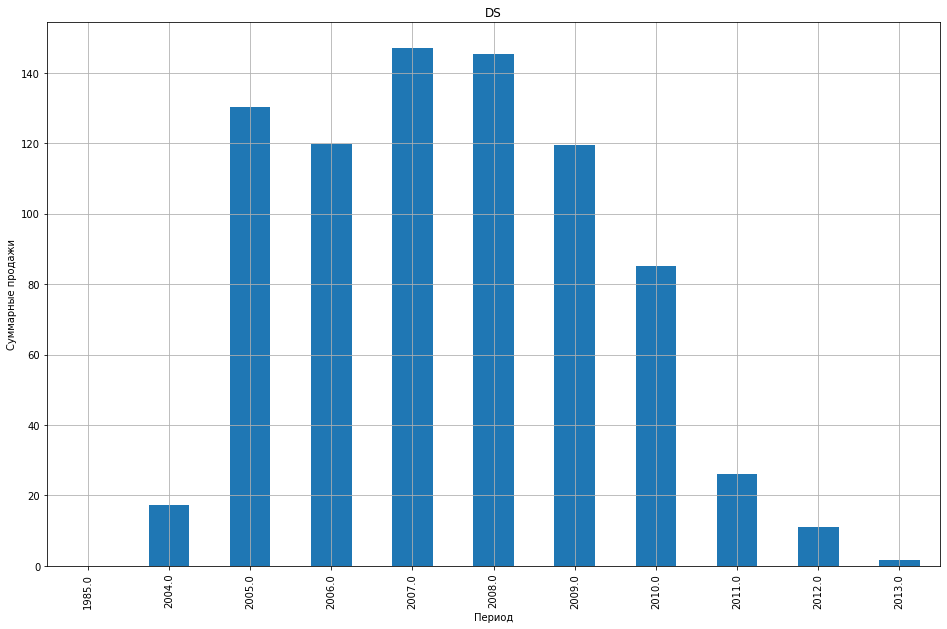

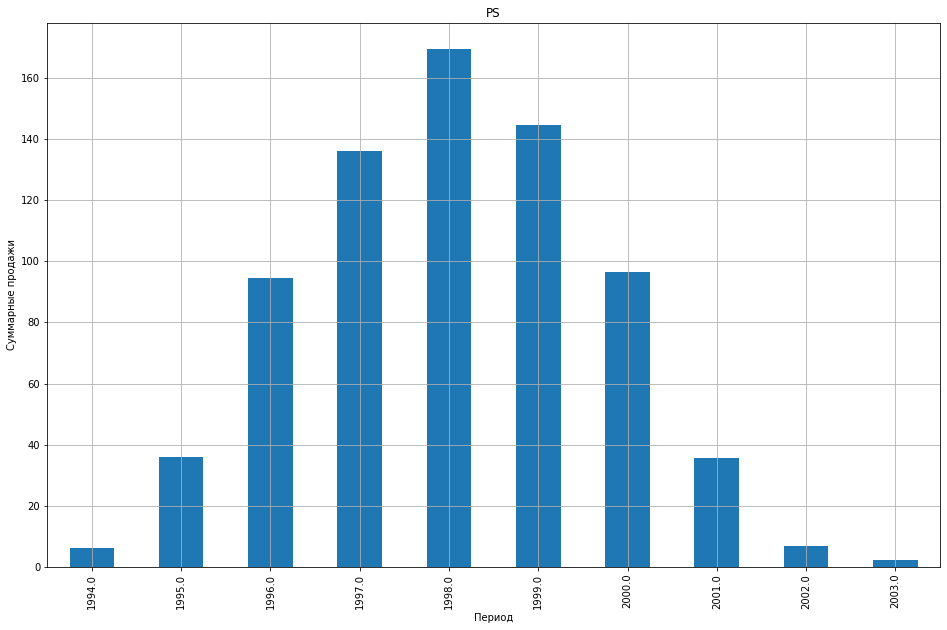

In [42]:
top_platform = ['PS2','X360','PS3','Wii','DS','PS']
for p in top_platform:
    (
    data.loc[(data['platform'] == p)&(data['year_of_release']<2999)]
    .pivot_table(index = 'year_of_release',values = 'total_sales',aggfunc = 'sum')
    .plot(kind = 'bar',grid = True,legend = False,figsize = (16,10))
    )
    plt.title(p)
    plt.ylabel('Суммарные продажи')
    plt.xlabel('Период')
    plt.show()

**Можно увидеть, что за 10 лет платформа появляется, развивается и выходит из оборота**

In [43]:
df = data[data['year_of_release']>2011]
df.groupby(by = 'platform')['total_sales'].sum().sort_values(ascending = False)

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64

**Я выбрала период 2012-2016 год, так как исходя из предыдущего вывода, что за 10 лет происходит полноценное развитие платформы, и взяв данные за последние пять лет, можно составить примерный прогноз как минимум на следующие 5 лет, в том числе и на 2017 год.** 

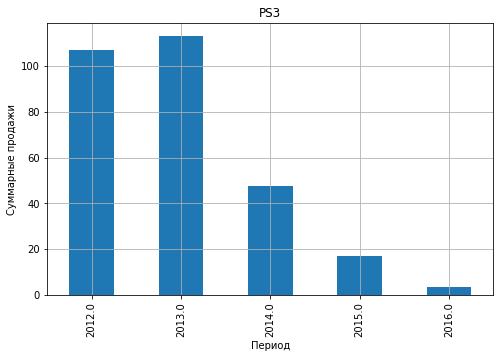

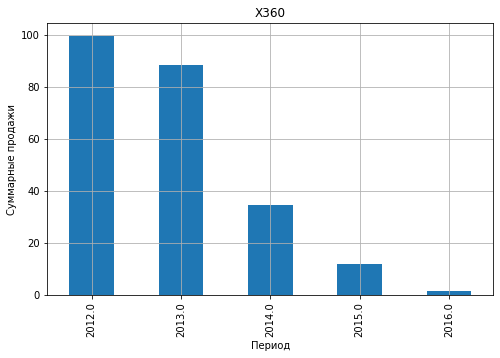

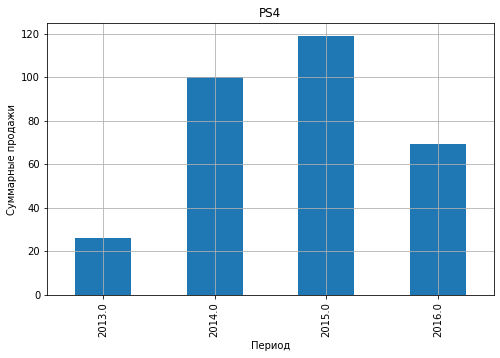

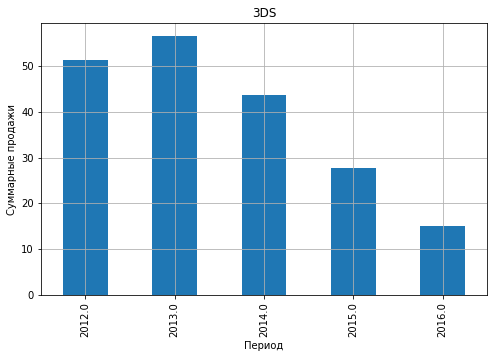

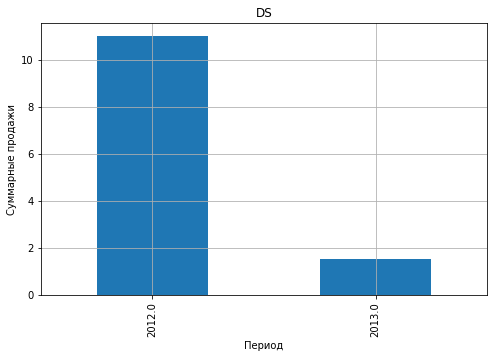

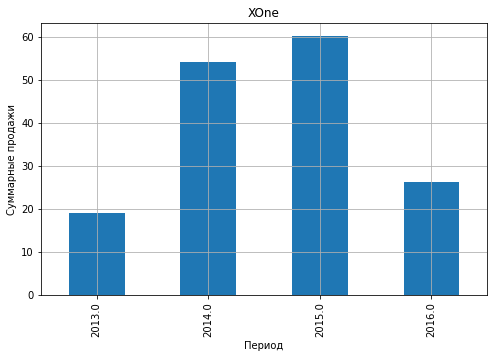

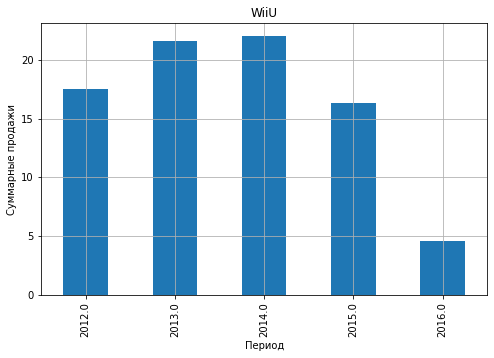

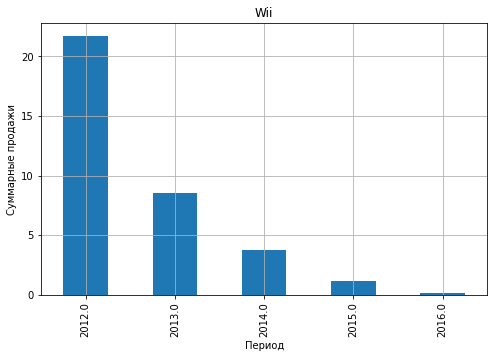

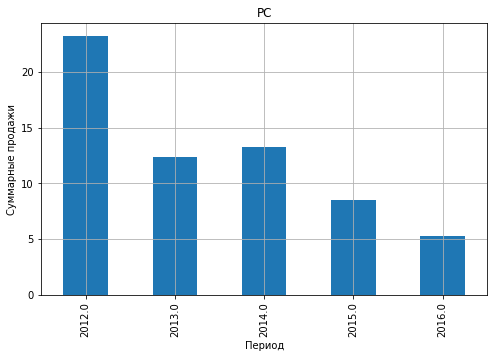

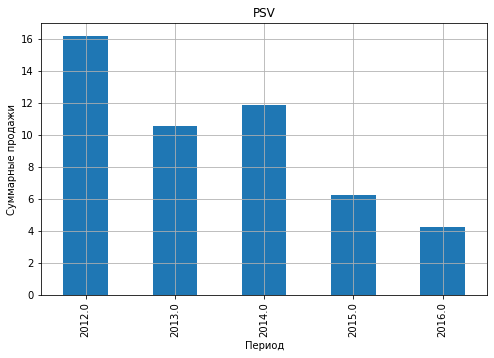

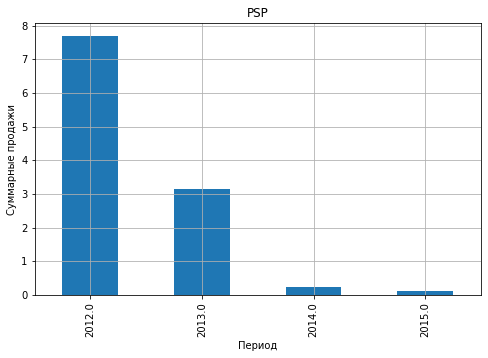

In [44]:
top_now_platforms = df['platform'].unique()

for p in top_now_platforms:
    (
    df.loc[df['platform'] == p]
    .pivot_table(index = 'year_of_release',values = 'total_sales',aggfunc = 'sum')
    .plot(kind = 'bar',grid = True,legend = False,figsize = (8,5))
    )
    plt.title(p)
    plt.ylabel('Суммарные продажи')
    plt.xlabel('Период')
    plt.show()

**По графикам видно, что платформa PS4 сейчас находится на пике своей популярности,а продажи XOne и 3DS, хоть и снижаются, все равно довольно высоки по сравнению с остальными, поэтому я бы выделила их в потенциально прибыльные в 2017 году. У остальных платформ наблюдается спад продаж, поэтому в 2017 году, скорее всего, они не будут популярны.**

# График «ящик с усами» по глобальным продажам игр в разбивке по платформам

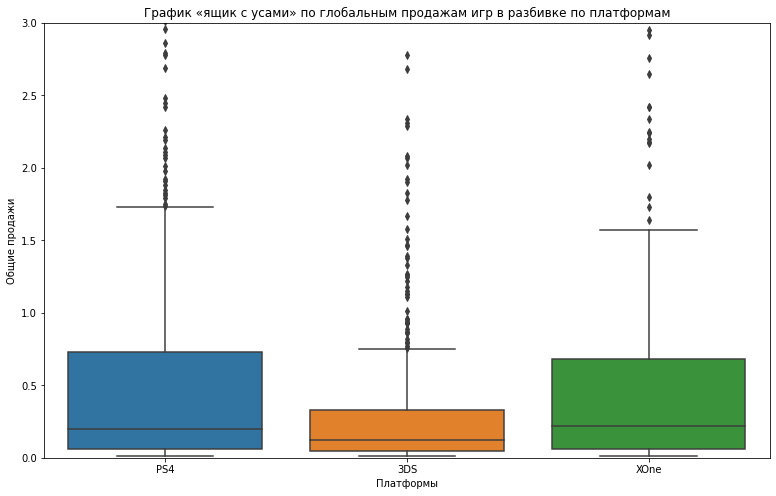

In [56]:
import seaborn as sns

data_actual_platforms = data.query('platform in["PS4","XOne","3DS"]')

plt.figure(figsize=(13, 8))
box = sns.boxplot(x="platform", y="total_sales", data = data_actual_platforms).set(title = 'График «ящик с усами» по глобальным продажам игр в разбивке по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 3))


In [57]:
display(data.query('platform == "PS4"')['total_sales'].describe())
plt.show()

count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

In [58]:
display(data.query('platform == "XOne"')['total_sales'].describe())
plt.show()

count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64

In [59]:
display(data.query('platform == "3DS"')['total_sales'].describe())
plt.show()

count    512.000000
mean       0.503535
std        1.441271
min        0.010000
25%        0.050000
50%        0.120000
75%        0.332500
max       14.600000
Name: total_sales, dtype: float64

**Результат:**
На всех платформах есть выбросы с нетипично большими продажами по определенным играм, которые превышают среднее в 10-20 раз. У всех платформ среднее меньше единицы, среднеквадратичное отклонение - больше единицы, но меньше двух (продажи даны в миллионах копий).

# Построение диаграммы рассеивания и рассчет корреляции между отзывами и продажами

-0.031957110204556376


<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

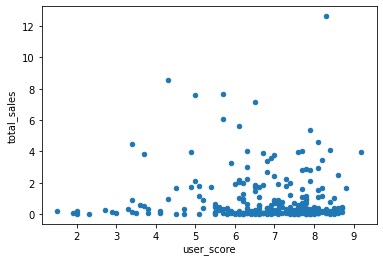

In [62]:
data_PS4 = data[(data['platform'] == 'PS4')&(data['user_score']!=0)]
print(data_PS4['total_sales'].corr(data_PS4['user_score']))
data_PS4.plot(x='user_score', y='total_sales', kind='scatter')

0.08810965475792913


<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

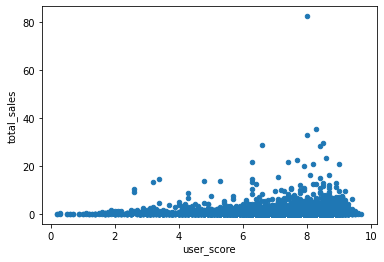

In [63]:
data1 = data[data['user_score']!=0]
print(data1['total_sales'].corr(data1['user_score']))
data1.plot(x='user_score', y='total_sales', kind='scatter')

0.2453488454741138


<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

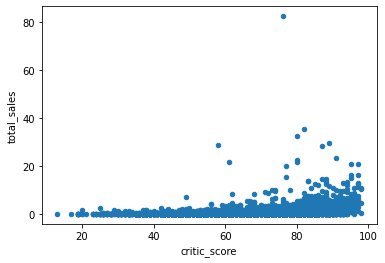

In [64]:
data2 = data[data['critic_score']!=0]
print(data2['total_sales'].corr(data2['critic_score']))
data2.plot(x='critic_score', y='total_sales', kind='scatter')

**Как и в случае самой популярной платформы PS4, так и в целом, корреляция между рейтингом пользователей и критиков и общими продажами достаточно мала, но в случае с PS4 значение коэффициента корреляции со знаком минус, то есть наблюдается очень слабая обратная связь. Наибольшее значение коэффициента корреляции наблюдается у общих продаж и оценкой критиков, коэффициент равен почти 0.25.**

# Распределение игр по жанрам

genre
Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: total_sales, dtype: int64


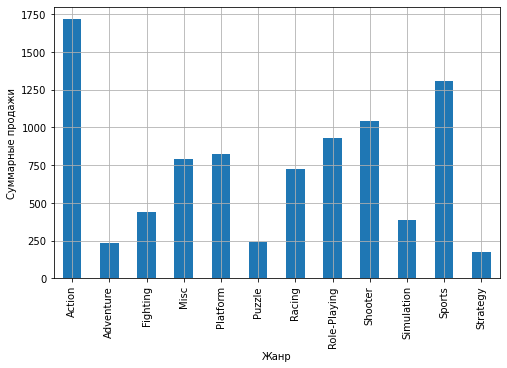

In [19]:
print(data.groupby(by = 'genre')['total_sales'].count().sort_values(ascending = False))
data.pivot_table(index = 'genre',values = 'total_sales',aggfunc = 'sum').plot(kind = 'bar',grid = True,legend = False,figsize = (8,5))
plt.ylabel('Суммарные продажи')
plt.xlabel('Жанр')
plt.show() 

In [ ]:
Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах?
Выделяются ли жанры с высокими и низкими продажами?

Среднее значение продаж для жанра Sports 0.567940156114484
Медианное значение продаж для жанра Sports 0.22000000000000003

Среднее значение продаж для жанра Platform 0.9402619589977221
Медианное значение продаж для жанра Platform 0.27

Среднее значение продаж для жанра Racing 0.5901223491027733
Медианное значение продаж для жанра Racing 0.19

Среднее значение продаж для жанра Role-Playing 0.628683322079676
Медианное значение продаж для жанра Role-Playing 0.18000000000000002

Среднее значение продаж для жанра Puzzle 0.4215992970123023
Медианное значение продаж для жанра Puzzle 0.09999999999999999

Среднее значение продаж для жанра Misc 0.4592039511911679
Медианное значение продаж для жанра Misc 0.16

Среднее значение продаж для жанра Shooter 0.8035185185185184
Медианное значение продаж для жанра Shooter 0.24

Среднее значение продаж для жанра Simulation 0.4526954492415403
Медианное значение продаж для жанра Simulation 0.15000000000000002

Среднее значение продаж для жанра Action 0.51905

<BarContainer object of 12 artists>

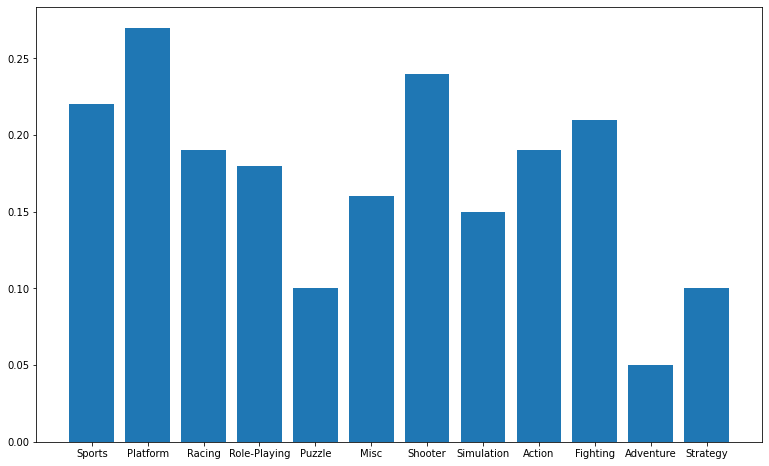

In [99]:
genre = data['genre'].unique()
median_genre = []
mean_genre = []
for g in genre:
    data_g = data[data['genre'] == g]
    median_genre.append(data_g['total_sales'].median())
    mean_genre.append(data_g['total_sales'].mean())
plt.figure(figsize=(13, 8))
plt.bar(genre, median_genre)

<BarContainer object of 12 artists>

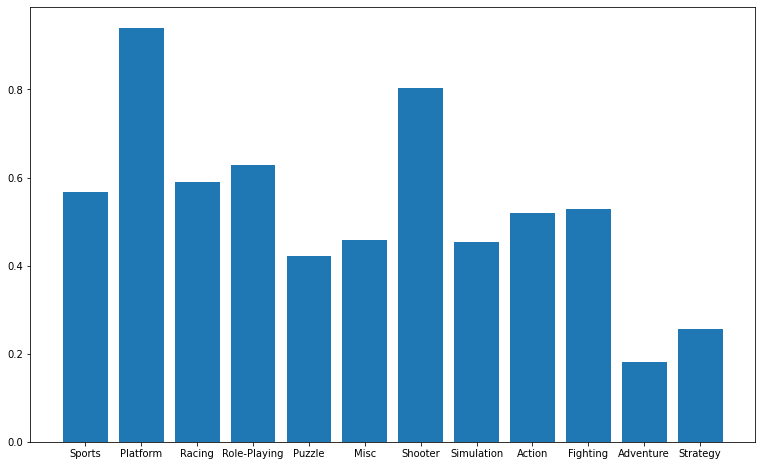

In [100]:
plt.figure(figsize=(13, 8))
plt.bar(genre, mean_genre)

Исходя из данных в таблице видно, что  самые массовые жанры - это Action,Sports и Misc. Также по графику можно понять, что самые
высокие продажи приносит Action, Sports и Shooter,а самые низкие - Strategy, Puzzle и Adventure. **Но если рассчитать медианное и среднее значение продаж для каждого жанра, то можно увидеть, что суммарные продажи некорректно отображают прибыльность жанра.**

**На гистограммах видно, что наибольшая медиана и среднее у игр жанра Platform и Shooter,а наименьшее - Adventure,Strategy,Pazzl.**

# **Европа**

In [103]:
eu_top = data.groupby(by = 'platform')['eu_sales'].sum().sort_values(ascending = False)
total_top = data.groupby(by = 'platform')['total_sales'].sum().sort_values(ascending = False)
print(eu_top.head(5))
index = eu_top.head(5).index.tolist()
for i in index:
    print('Доля продаж в Европе',i,'составляет',eu_top[i]/total_top[i])
    


platform
PS2     332.63
PS3     327.21
X360    268.32
Wii     258.32
PS      212.39
Name: eu_sales, dtype: float64
Доля продаж в Европе PS2 составляет 0.26965044262135557
Доля продаж в Европе PS3 составляет 0.35133248867223366
Доля продаж в Европе X360 составляет 0.2791394448836893
Доля продаж в Европе Wii составляет 0.28986287843084463
Доля продаж в Европе PS составляет 0.29191291679265763


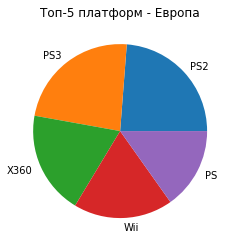

In [104]:
(
    eu_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 платформ - Европа")
plt.ylabel("")
plt.show()

In [114]:
genre_eu_top = data.groupby(by = 'genre')['eu_sales'].sum().sort_values(ascending = False)
genre_eu_top.head(5)

genre
Action     510.99
Sports     371.33
Shooter    314.52
Racing     234.49
Misc       210.60
Name: eu_sales, dtype: float64

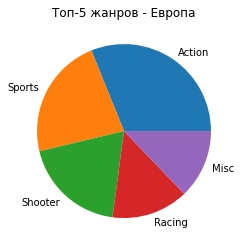

In [116]:
(
    genre_eu_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 жанров - Европа")
plt.ylabel("")
plt.show()

In [117]:
rating_eu_top = data.groupby(by = 'rating')['eu_sales'].sum().sort_values(ascending = False)


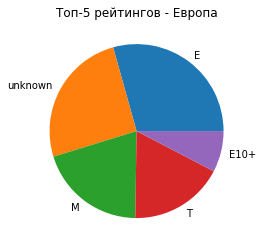

In [119]:
(
    rating_eu_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 рейтингов - Европа")
plt.ylabel("")
plt.show()

**Вывод**
Самыми популярными в Европе платформами являются PS2,PS3,X360. Доли продаж в Европе относительно всех продаж по каждой платформе - примерно 1\3.
Самыми популярными жанрами являются те же самые Action, Sports и Shooter, много продаж приносят игры с рейтингом Е,М,Т. 

# **Япония**

In [106]:
jp_top = data.groupby(by = 'platform')['jp_sales'].sum().sort_values(ascending = False)
print(jp_top.head(5))
index = jp_top.head(5).index.tolist()
for i in index:
    print('Доля продаж в Японии',i,'составляет',jp_top[i]/total_top[i])

platform
DS      175.02
PS      139.78
PS2     137.54
SNES    116.55
3DS     100.62
Name: jp_sales, dtype: float64
Доля продаж в Японии DS составляет 0.21801738957124453
Доля продаж в Японии PS составляет 0.19211633085021693
Доля продаж в Японии PS2 составляет 0.11149842731606222
Доля продаж в Японии SNES составляет 0.5826334733053381
Доля продаж в Японии 3DS составляет 0.3902874209689332


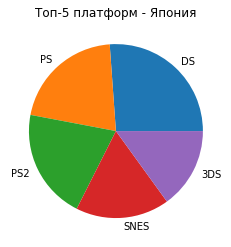

In [108]:
(
    jp_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 платформ - Япония")
plt.ylabel("")
plt.show()

In [120]:
genre_jp_top = data.groupby(by = 'genre')['jp_sales'].sum().sort_values(ascending = False)
genre_jp_top.head(5)

genre
Role-Playing    353.39
Action          160.14
Sports          134.93
Platform        130.71
Misc            107.02
Name: jp_sales, dtype: float64

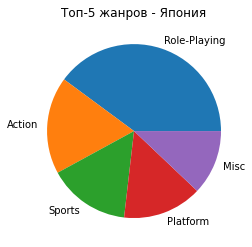

In [122]:
(
    genre_jp_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 жанров - Япония")
plt.ylabel("")
plt.show()

In [126]:
rating_jp_top = data.groupby(by = 'rating')['jp_sales'].sum().sort_values(ascending = False)

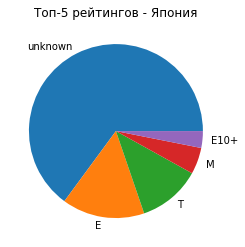

In [131]:
(
    rating_jp_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 рейтингов - Япония")
plt.ylabel("")
plt.show()

**Вывод**
Самыми популярными в Японии платформами являются DS,PS,PS2. Доли продаж в Японии относительно всех продаж по каждой платформе -  у топ-3 платформы примерно 1\5, у двух остальных - почти половина.
Самыми популярными жанрами являются Action, Sports и Role-Playing , много продаж приносят игры с рейтингом Е,М,Т, но самое большое количество игр - больше половины игр в Японии - это игры без рейтинга ( на диаграмме 'unknown'). Возможно, причиной этому послужила специфика японского рынка (какие-то строгие ограничения по рейтингу, запрет продажи подросткам игр с рейтингом 18+ и тд.).

# **Америка**

In [111]:
na_top = data.groupby(by = 'platform')['na_sales'].sum().sort_values(ascending = False)
print(na_top.head(5))
index = na_top.head(5).index.tolist()
for i in index:
    print('Доля продаж в Америке',i,'составляет',na_top[i]/total_top[i])

platform
X360    595.74
PS2     572.92
Wii     486.87
PS3     390.13
DS      380.31
Name: na_sales, dtype: float64
Доля продаж в Америке X360 составляет 0.6197619741167667
Доля продаж в Америке PS2 составляет 0.4644443723856142
Доля продаж в Америке Wii составляет 0.5463206086312546
Доля продаж в Америке PS3 составляет 0.41889106019284106
Доля продаж в Америке DS составляет 0.4737412491591781


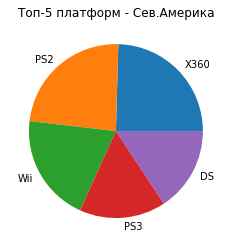

In [112]:
(
    na_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 платформ - Сев.Америка")
plt.ylabel("")
plt.show()

In [110]:
genre_na_top = data.groupby(by = 'genre')['na_sales'].sum().sort_values(ascending = False)
genre_na_top.head(5)

genre
Action      863.17
Sports      671.20
Shooter     584.83
Platform    444.44
Misc        399.57
Name: na_sales, dtype: float64

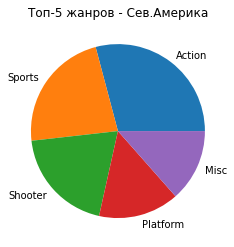

In [124]:
(
    genre_na_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 жанров - Сев.Америка")
plt.ylabel("")
plt.show()

In [128]:
rating_na_top = data.groupby(by = 'rating')['na_sales'].sum().sort_values(ascending = False)

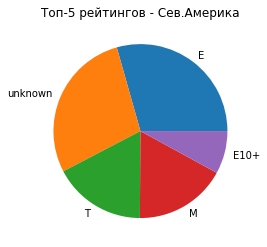

In [130]:
(
    rating_na_top.head(5)
    .plot(kind='pie', figsize=(6,4))
)
plt.title("Топ-5 рейтингов - Сев.Америка")
plt.ylabel("")
plt.show()

**Вывод**
Самыми популярными в Америке платформами являются Х360,Wii,PS2. Доли продаж в Америке относительно всех продаж по каждой платформе - около половины, это достаточно много, учитывая большой рынок в Азии,Европе и других странах.
Самыми популярными жанрами являются Action, Sports и Shooter, много продаж приносят игры с рейтингом Е,М,Т. 

**Общий вывод**
По статистике, жанры Action и Sports являются самыми популярными И для Европы, и для Японии, и для Америки.Также можно сказать, что во всех регионах самый популярный рейтинг от организации ESRB - это Е, в тройку лидеров так же входят М и Т, то есть в отдельных регионах рейтинг не влияет на количество продаж.

# **Статистический анализ**

Для сравнения средних значений двух независимых выборок с неизвестными дисперсиями я быбрала критерий Стьюдента  - ttest_ind c указанием параметра equal_var = False.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC равны

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не равны

In [133]:
xone = data[(data['platform'] =='XOne')&(data['year_of_release']>2011)]['user_score']
pc = data[data[('platform'] =='PC')&(data['year_of_release']>2011))]['user_score']

xone = xone[xone != 0]
pc = pc[pc != 0]

results = st.ttest_ind(xone,pc,equal_var = False)
alpha = 0.05
print(results.pvalue)
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

4.5385802963771835e-06
Отвергаем нулевую гипотезу 


Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны 

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports равны

In [134]:
action = data[(data['genre'] =='Action')&(data['year_of_release']>2011)]['user_score']
sports = data[(data['genre'] =='Sports')&(data['year_of_release']>2011))]['user_score']

action = action[action != 0]
sports = sports[sports != 0]

results = st.ttest_ind(action,sports,equal_var = False)
alpha = 0.05
print(results.pvalue)
if results.pvalue<alpha:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу ')

0.10412255479966635
Отвергаем нулевую гипотезу 


# **Общий вывод**

В проекте я выполнила несколько этапов работы с данными - первым из них была предобработка данных: 
* первоначальный просмотр таблицы и изучение подробной информации с помощью метода info()
* удаление или замена пропусков
* изменение формата некоторых столбцов,добавление новых полей

Затем провела исследовательский анализ данных, где проанализировала платформы с наибольшим количеством продаж и составила прогноз на 2017 год, где выделила самые перспективные компании, такие как PS4, XOne и 3DS, так же изучила самые популярные жанры игр, выделила жанры с наибольшим и наименьшим количеством продаж (наибольшее медианное и среднее значения количества продаж у игр жанра Platform и Shooter,а наименьшее - Adventure,Strategy,Pazzl), а так же выявила слабую зависимость между количеством продаж и отзывами критиков, или отсутствие зависимости между пользовательским рейтингом и количеством продаж.

В последнем этапе я проверила две гипотезы о равенстве и отличии средних значений пользовательских рейтингов у двух платформ (XBox и Pc) и двух жанров (Action и Sports), используя критерий Стьюдента, и оказалось, что средние пользовательские рейтинги платформ Xbox One и PC не равны, а средние пользовательские рейтинги жанров Action и Sports наоборот примерно одинаковы.

Стоит обратить внимание на то, что иногда просмотр суммарных продаж дает неверное понятие о ситуации, поэтому я рекомендую проверять и другие метрики. Также стоит обратить внимание, что данные лучше анализировать на актуальном периоде, чтобы получить наиболее точную картину рынка игр и возможность ее спрогнозировать на ближайшее будущее. 